In [ ]:
import numpy as np
import os
import glob 
import time 
import pandas as pd
import shutil
import re
import mdtraj as md
import MDAnalysis as mda
import pickle
import pickle as p 
import csv
import sys
import subprocess
import xml.etree.ElementTree as ET
import requests
import concurrent.futures
import multiprocessing
import nglview as nv
import h5py
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.patches as patches
import html
import biobox as bb
import tempfile
import matplotlib.pyplot as plt
import molearn
import torch
import glob as glob
import MDAnalysis.analysis.rms as rms
import seaborn as sns
import pickle
import networkx as nx
sys.path.insert(0, os.path.join(os.path.abspath(os.pardir),'src'))

from Bio import PDB
from tqdm import tqdm
from time import time as t
from urllib.request import urlretrieve as download
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Blast.Applications import NcbipsiblastCommandline
from collections import defaultdict
from Bio.PDB import PPBuilder
from Bio.SeqUtils import seq1
from modeller import *
from modeller.automodel import *
from Bio.PDB import PDBParser
from MDAnalysis.analysis import align
from mpi4py import MPI
from glob import glob
from pprint import pprint as pp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from glob import glob as g
from tqdm.notebook import tqdm
from collections import Counter
from matplotlib.ticker import FuncFormatter
from collections import defaultdict
from pymol import cmd
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from scipy import stats
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from matplotlib.colors import BoundaryNorm
from numpy.linalg import norm
from molearn.data import PDBData
from molearn.trainers import Trainer
from molearn.models.small_foldingnet import Small_AutoEncoder
from molearn.analysis.analyser import MolearnAnalysis
from copy import deepcopy
from molearn.analysis import MolearnGUI
from scipy.ndimage import rotate
from numpy.linalg import inv
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score
from itertools import combinations
from urllib.request import urlretrieve
from urllib.error import URLError
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn import tree
from scipy.stats import pearsonr


Strip loops to only carbon-alphas.

In [ ]:
"""
This script filters pre-aligned kinase structures to retain only those with both DFG and APE motifs properly aligned. It extracts the corresponding segment between these motifs, records alignment metadata, and saves the results for downstream analysis. A summary CSV file is also generated to indicate alignment status for each structure.
"""

# Check if the aligned data file exists
if os.path.exists('aligned_data.pkl'):
    print("Loading aligned data from file...")
    with open('aligned_data.pkl', 'rb') as f:
        aligned = pickle.load(f)
    print(f"Loaded {len(aligned)} aligned structures")
else:
    # Raise an error if the file is not found
    raise FileNotFoundError("aligned_data.pkl not found. Please run the alignment block first.")

#Filter out structures without "DFG" or "APE" in sequence
count = 0
new_aligned = []
bad = []

for k, a in enumerate(aligned):
    if a.seq1.find("DFG") == -1 or a.seq1.find("APE") == -1:
        bad.append(a)   # Sequences without DFG or APE are marked as "bad"
        count += 1
    else:
        new_aligned.append(a)  # Keep sequences that contain both motifs

print(count, "/", len(aligned), " don't match.")
print(f"Continuing with {len(new_aligned)} structures")

# Save the filtered structures after initial screening
with open('new_aligned_data.pkl', 'wb') as f:
    pickle.dump(new_aligned, f)
print(f"Saved {len(new_aligned)} filtered structures to 'new_aligned_data.pkl'")

# Only keep structures where both DFG and APE are not aligned to gaps ("-")
counts = {}
counter = 0
new_aligned2 = []
aligning_segs = {}
lengths = []

for a in new_aligned:
    DFG_index = a.seq1.find("DFG")
    APE_index = a.seq1.find("APE")
    dfg = a.seq2[DFG_index]
    ape = a.seq2[APE_index]
    
    if dfg != "-" and ape != "-":         # Check if both motifs are properly aligned
        counter += 1
        length = APE_index - DFG_index
        counts.setdefault(length, []).append((a.name, DFG_index, APE_index))
        new_aligned2.append(a)
        aligning_segs.setdefault(a.name,
                                 (a.seq2[DFG_index:DFG_index+3],   # aligned DFG
                                  a.seq2[APE_index:APE_index+3],   # aligned APE
                                  a.seq2[DFG_index:APE_index+3]))
        lengths.append(len(a.seq2[DFG_index:APE_index+3]))

print(f"{counter} structures with an alignment to the D and A")

# Save final filtered results with aligned segments
with open('filtered_aligned_data.pkl', 'wb') as f:
    filtered_data = {
        'new_aligned2': new_aligned2,
        'aligning_segs': aligning_segs,
        'counts': counts,
        'lengths': lengths
    }
    pickle.dump(filtered_data, f)
print(f"Saved {len(new_aligned2)} final filtered structures to 'filtered_aligned_data.pkl'")

with open('alignment_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Name', 'Seq1 Segment', 'Seq2 Segment', 'Status'])
    
    # Write aligned structures
    for a in new_aligned2:
        DFG_index = a.seq1.find("DFG")
        APE_index = a.seq1.find("APE")
        seq1_segment = a.seq1[DFG_index:APE_index+3]
        seq2_segment = a.seq2[DFG_index:APE_index+3]
        writer.writerow([a.name, seq1_segment, seq2_segment, 'Aligned'])

    for a in bad:
        writer.writerow([a.name, '', '', 'Not Aligned'])

Loading aligned data from file...
Loaded 3808 aligned structures
153 / 3808  don't match.
Continuing with 3655 structures
Saved 3655 filtered structures to 'new_aligned_data.pkl'
3593 structures with an alignment to the D and A
Saved 3593 final filtered structures to 'filtered_aligned_data.pkl'


In [ ]:
"""
This script extracts the C-alpha atoms between the DFG and APE motifs from structurally aligned kinase models. It corrects for alignment gaps, isolates the target region, and saves the trimmed segments for downstream structural analysis.
"""
# Load a PDB file and extract only the alpha carbon (CA) atoms 
# from a given residue range (start_residue is inclusive, end_residue is exclusive)
def strip_to_ca(pdb_path, start_residue, end_residue):
    pdb = md.load(pdb_path)
    print(f"Loaded PDB: {pdb_path}")

    # Identify the atom indices corresponding to CA atoms in the specified residue range
    atom_indices = [
        atom.index 
        for res in pdb.top._residues[start_residue:end_residue] 
        for atom in res.atoms 
        if atom.name == "CA"
    ]
    print(f"Atom indices for CA: {atom_indices}")

    return pdb.atom_slice(atom_indices)

# For each alignment object, find the corresponding PDB file, extract the aligned DFG–APE segment,
# and save only its CA atoms to a new file
def process_alignments(pdb_dir, target_dir, alignments):
    os.makedirs(target_dir, exist_ok=True)
    print(f"\nProcessing:\n  PDB directory = {pdb_dir}\n  Target directory = {target_dir}")

    pdb_files = glob(os.path.join(pdb_dir, "*.pdb"))
    print(f"Found PDB files: {pdb_files}")

    for align_obj in tqdm(alignments, desc="Processing alignments"):
        print(f"\nChecking alignment: {align_obj.name}")
        match_found = False
        matching_fp = ""

        # Try to match the alignment object with a PDB filename
        for fp in pdb_files:
            if align_obj.name in fp and "pdb" in fp:
                match_found = True
                matching_fp = fp
                print(f"Match found for {align_obj.name} in file: {fp}")
                break
        
        if not match_found:
            print(f"No match found for {align_obj.name}, skipping.")
            continue
        
        # Identify positions of the DFG and APE motifs in the reference sequence
        DFG_index = align_obj.seq1.find("DFG")
        APE_index = align_obj.seq1.find("APE")
        print(f"DFG index (in seq1): {DFG_index} | APE index (in seq1): {APE_index}")
        
        # Skip if either motif is missing
        if DFG_index == -1 or APE_index == -1:
            print(f"Skipping file {matching_fp} as it does not contain the DFG or APE motifs in seq1.")
            continue

        # Ensure the DFG motif is properly aligned (not disrupted by gaps)
        if align_obj.seq2[DFG_index:DFG_index + 3] != "DFG":
            print(f"Skipping file {matching_fp} as the DFG motif is not aligned properly in seq2.")
            continue
        
        DFG_index_adjusted = DFG_index - sum([1 for a in align_obj.seq2[:DFG_index] if a == "-"])
        APE_index_adjusted = APE_index - sum([1 for a in align_obj.seq2[:APE_index] if a == "-"])
        print(f"Adjusted DFG index: {DFG_index_adjusted} | Adjusted APE index: {APE_index_adjusted}")

        # Extract CA atoms in the aligned DFG–APE segment
        stripped = strip_to_ca(matching_fp, DFG_index_adjusted, APE_index_adjusted + 3)

        new_name = os.path.join(target_dir, os.path.basename(matching_fp))
        print(f"Saving stripped PDB to: {new_name}")
        stripped.save(new_name)

# Run the processing using specified directories and the new_aligned2 list
if __name__ == "__main__":

    pdb_dir_aligned = "Results/activation_segments/Mustang_with_singlechain/"
    target_dir_aligned = f"Results/activation_segments/CA_segments/mustang_endsAlignment"
    process_alignments(pdb_dir_aligned, target_dir_aligned, new_aligned2)



Processing:
  PDB directory = Results/activation_segments/Mustang_with_singlechain/
  Target directory = Results/activation_segments/CA_segments/mustang_endsAlignment
Found PDB files: ['Results/activation_segments/Mustang_with_singlechain/1AD5_A.pdb', 'Results/activation_segments/Mustang_with_singlechain/1AD5_B.pdb', 'Results/activation_segments/Mustang_with_singlechain/1AGW_A.pdb', 'Results/activation_segments/Mustang_with_singlechain/1APM_E.pdb', 'Results/activation_segments/Mustang_with_singlechain/1ATP_E.pdb', 'Results/activation_segments/Mustang_with_singlechain/1B38_A.pdb', 'Results/activation_segments/Mustang_with_singlechain/1B39_A.pdb', 'Results/activation_segments/Mustang_with_singlechain/1BI7_A.pdb', 'Results/activation_segments/Mustang_with_singlechain/1BI8_A.pdb', 'Results/activation_segments/Mustang_with_singlechain/1BI8_C.pdb', 'Results/activation_segments/Mustang_with_singlechain/1BKX_A.pdb', 'Results/activation_segments/Mustang_with_singlechain/1BLX_A.pdb', 'Results/a

Processing alignments:   0%|          | 0/3593 [00:00<?, ?it/s]


Checking alignment: 1A9U_A
No match found for 1A9U_A, skipping.

Checking alignment: 1AD5_A
Match found for 1AD5_A in file: Results/activation_segments/Mustang_with_singlechain/1AD5_A.pdb
DFG index (in seq1): 328 | APE index (in seq1): 355
Adjusted DFG index: 320 | Adjusted APE index: 336
Loaded PDB: Results/activation_segments/Mustang_with_singlechain/1AD5_A.pdb
Atom indices for CA: [3094, 3103, 3115, 3120, 3129, 3135, 3141, 3147, 3152, 3158, 3164, 3176, 3183, 3192, 3205, 3221, 3230, 3236, 3243]
Saving stripped PDB to: Results/activation_segments/CA_segments/mustang_endsAlignment/1AD5_A.pdb

Checking alignment: 1AD5_B
Match found for 1AD5_B in file: Results/activation_segments/Mustang_with_singlechain/1AD5_B.pdb
DFG index (in seq1): 328 | APE index (in seq1): 356
Adjusted DFG index: 320 | Adjusted APE index: 336
Loaded PDB: Results/activation_segments/Mustang_with_singlechain/1AD5_B.pdb
Atom indices for CA: [3094, 3103, 3115, 3120, 3129, 3135, 3141, 3147, 3152, 3158, 3164, 3176, 3183

In [ ]:
def count_pdb_files(directory):
    directory = os.path.join(directory, '')

    pdb_files = glob(os.path.join(directory, '*.pdb'))

    return len(pdb_files)

pdb_directory = 'Results/activation_segments/CA_segments/mustang_endsAlignment'

pdb_count = count_pdb_files(pdb_directory)

print(f"There are {pdb_count} PDB files in the directory '{pdb_directory}'.")

There are 2978 PDB files in the directory 'Results/activation_segments/CA_segments/mustang_endsAlignment'.


Getting rid of outlier loops based on carbon-alpha count.

################################################################################
RUNNING TUKEY'S OUTLIER DETECTION WITH k = 1.5
################################################################################
Found 2978 PDB files in Results/activation_segments/CA_segments/mustang_endsAlignment


Analyzing CA segments: 100%|██████████| 2978/2978 [00:45<00:00, 66.03it/s]



ORIGINAL DATASET STATISTICS
Total structures: 2978
CA counts - Min: 8, Max: 63, Mean: 27.35, Median: 27.00

TUKEY'S OUTLIER DETECTION - CA COUNTS
Q1: 26.00, Q3: 29.00, IQR: 3.00
Lower bound: 21.50, Upper bound: 33.50
Outliers found: 110 out of 2978 (3.7%)
CA count outliers:
  - 1AD5_A.pdb: 19 CA atoms
  - 1AD5_B.pdb: 19 CA atoms
  - 2CN5_A.pdb: 38 CA atoms
  - 2HCK_A.pdb: 19 CA atoms
  - 2HCK_B.pdb: 19 CA atoms
  - 2W0J_A.pdb: 11 CA atoms
  - 2W7X_A.pdb: 15 CA atoms
  - 2WTC_A.pdb: 36 CA atoms
  - 2WTD_A.pdb: 36 CA atoms
  - 2WTI_A.pdb: 11 CA atoms
  - 2WTJ_A.pdb: 11 CA atoms
  - 2XBJ_A.pdb: 36 CA atoms
  - 2XK9_A.pdb: 38 CA atoms
  - 2XM9_A.pdb: 15 CA atoms
  - 2YCF_A.pdb: 15 CA atoms
  - 2YCQ_A.pdb: 15 CA atoms
  - 2YCR_A.pdb: 38 CA atoms
  - 2YCS_A.pdb: 36 CA atoms
  - 2YIQ_A.pdb: 15 CA atoms
  - 2YIR_A.pdb: 15 CA atoms
  - 2YIT_A.pdb: 38 CA atoms
  - 3ALO_A.pdb: 11 CA atoms
  - 3BHY_A.pdb: 19 CA atoms
  - 4A9R_A.pdb: 38 CA atoms
  - 4A9T_A.pdb: 38 CA atoms
  - 4A9U_A.pdb: 36 CA at

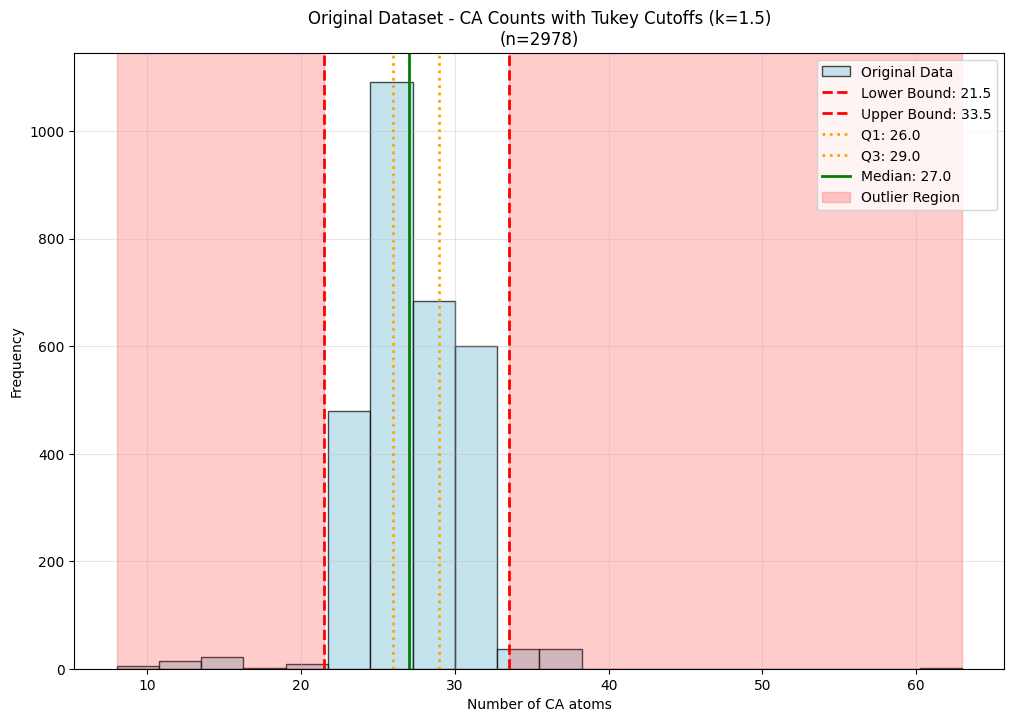

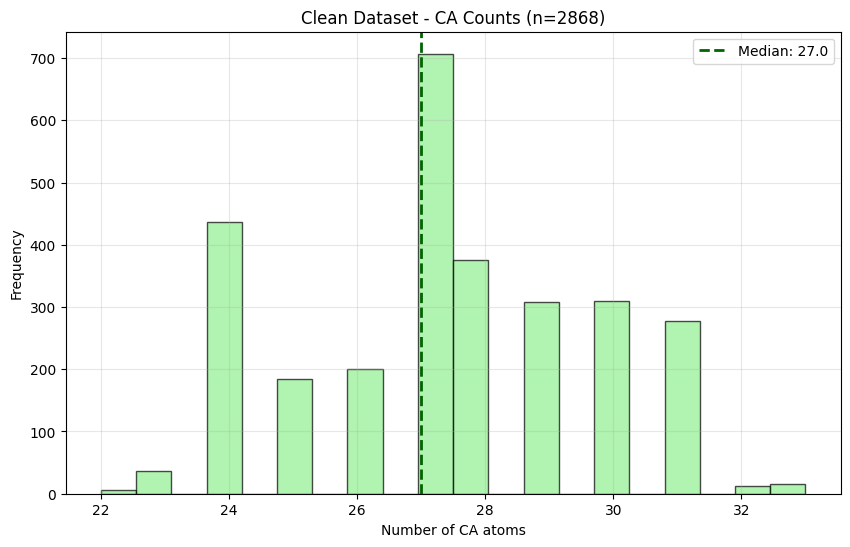

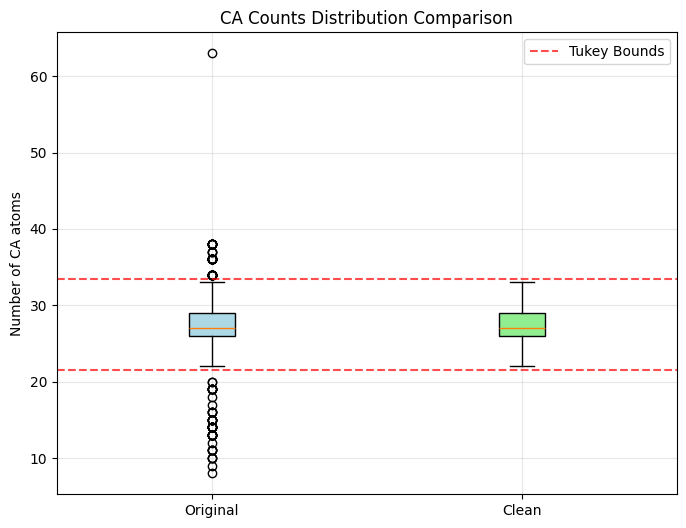


Copying clean structures to: Results/activation_segments/CA_segments/mustang_endsAlignment_cleaned


Copying clean files: 100%|██████████| 2868/2868 [01:17<00:00, 36.98it/s]

Created clean directory with 2868 structures
Outlier information saved to: outliers_removed_k1.5.csv
Clean dataset information saved to: clean_dataset_k1.5.csv

Final Results:
- Original dataset: 2978 structures
- Clean dataset: 2868 structures
- Outliers removed: 110 structures
- Outlier percentage: 3.7%
- Clean structures saved to: Results/activation_segments/CA_segments/mustang_endsAlignment_cleaned


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from glob import glob
from tqdm import tqdm
import pandas as pd
from scipy import stats
import shutil

# Perform Tukey's method to detect outliers based on the interquartile range (IQR)
def tukey_outlier_detection(data, k=1.5):
   
    data = np.array(data)
    
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    
    return outlier_indices, lower_bound, upper_bound, Q1, Q3, IQR

# Create histograms and boxplot to visualize CA atom count distributions and outliers
def create_plots(original_ca, clean_ca, output_dir, k_factor, ca_lower, ca_upper, ca_Q1, ca_Q3):
    plt.figure(figsize=(12, 8))
    
    # Histogram of original CA counts with Tukey bounds
    n, bins, patches = plt.hist(original_ca, bins=20, alpha=0.7, color='lightblue', edgecolor='black', label='Original Data')

    plt.axvline(x=ca_lower, color='red', linestyle='--', linewidth=2, label=f'Lower Bound: {ca_lower:.1f}')
    plt.axvline(x=ca_upper, color='red', linestyle='--', linewidth=2, label=f'Upper Bound: {ca_upper:.1f}')

    plt.axvline(x=ca_Q1, color='orange', linestyle=':', linewidth=2, label=f'Q1: {ca_Q1:.1f}')
    plt.axvline(x=ca_Q3, color='orange', linestyle=':', linewidth=2, label=f'Q3: {ca_Q3:.1f}')

    median_ca = np.median(original_ca)
    plt.axvline(x=median_ca, color='green', linestyle='-', linewidth=2, label=f'Median: {median_ca:.1f}')

    plt.axvspan(min(original_ca), ca_lower, alpha=0.2, color='red', label='Outlier Region')
    plt.axvspan(ca_upper, max(original_ca), alpha=0.2, color='red')
    
    plt.xlabel('Number of CA atoms')
    plt.ylabel('Frequency')
    plt.title(f'Original Dataset - CA Counts with Tukey Cutoffs (k={k_factor})\n(n={len(original_ca)})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'original_ca_distribution_with_cutoffs_k{k_factor}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

    # Histogram for clean CA-only structures
    plt.figure(figsize=(10, 6))
    
    n, bins, patches = plt.hist(clean_ca, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')

    clean_median = np.median(clean_ca)
    plt.axvline(x=clean_median, color='darkgreen', linestyle='--', linewidth=2, 
                label=f'Median: {clean_median:.1f}')
    
    plt.xlabel('Number of CA atoms')
    plt.ylabel('Frequency')
    plt.title(f'Clean Dataset - CA Counts (n={len(clean_ca)})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'clean_ca_distribution_k{k_factor}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

    
    plt.figure(figsize=(8, 6))
    
    box_data_ca = [original_ca, clean_ca]
    bp = plt.boxplot(box_data_ca, labels=['Original', 'Clean'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightgreen')
    plt.ylabel('Number of CA atoms')
    plt.title('CA Counts Distribution Comparison')
    plt.grid(True, alpha=0.3)

    plt.axhline(y=ca_lower, color='red', linestyle='--', alpha=0.7, label='Tukey Bounds')
    plt.axhline(y=ca_upper, color='red', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.savefig(os.path.join(output_dir, f'ca_boxplot_comparison_k{k_factor}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

# Main function: analyze CA-only PDB segments and remove outliers based on CA count
def analyze_ca_segments_with_outlier_removal(ca_segments_dir, k_factor=1.5):

    pdb_files = glob(os.path.join(ca_segments_dir, "*.pdb"))
    print(f"Found {len(pdb_files)} PDB files in {ca_segments_dir}")

    file_info = []

    # Count the number of atoms in each PDB (should all be Cα atoms)
    for pdb_file in tqdm(pdb_files, desc="Analyzing CA segments"):
        try:
            traj = md.load(pdb_file)
            
            num_ca = traj.n_atoms
            
            file_info.append({
                'filename': os.path.basename(pdb_file),
                'filepath': pdb_file,
                'ca_count': num_ca
            })
                
        except Exception as e:
            print(f"Error processing {pdb_file}: {e}")

    df = pd.DataFrame(file_info)

    ca_counts = df['ca_count'].values
    
    print(f"\n{'='*60}")
    print("ORIGINAL DATASET STATISTICS")
    print(f"{'='*60}")
    print(f"Total structures: {len(df)}")
    print(f"CA counts - Min: {ca_counts.min()}, Max: {ca_counts.max()}, Mean: {ca_counts.mean():.2f}, Median: {np.median(ca_counts):.2f}")

    # Run Tukey outlier detection
    ca_outlier_indices, ca_lower, ca_upper, ca_Q1, ca_Q3, ca_IQR = tukey_outlier_detection(ca_counts, k=k_factor)
    
    print(f"\n{'='*60}")
    print("TUKEY'S OUTLIER DETECTION - CA COUNTS")
    print(f"{'='*60}")
    print(f"Q1: {ca_Q1:.2f}, Q3: {ca_Q3:.2f}, IQR: {ca_IQR:.2f}")
    print(f"Lower bound: {ca_lower:.2f}, Upper bound: {ca_upper:.2f}")
    print(f"Outliers found: {len(ca_outlier_indices)} out of {len(ca_counts)} ({len(ca_outlier_indices)/len(ca_counts)*100:.1f}%)")
    
    if len(ca_outlier_indices) > 0:
        print("CA count outliers:")
        for idx in ca_outlier_indices:
            print(f"  - {df.iloc[idx]['filename']}: {df.iloc[idx]['ca_count']} CA atoms")

    clean_df = df.drop(df.index[ca_outlier_indices]).reset_index(drop=True)
    
    print(f"\n{'='*60}")
    print("OUTLIER REMOVAL BASED ON CA COUNTS")
    print(f"{'='*60}")
    print(f"Outliers to remove: {len(ca_outlier_indices)} out of {len(df)} ({len(ca_outlier_indices)/len(df)*100:.1f}%)")
    print(f"Clean dataset size: {len(clean_df)} structures")

    if len(ca_outlier_indices) > 0:
        print("\nStructures being removed as outliers:")
        outlier_df = df.iloc[ca_outlier_indices]
        for _, row in outlier_df.iterrows():
            print(f"  - {row['filename']}: {row['ca_count']} CA atoms")

    clean_ca_counts = clean_df['ca_count'].values
    
    print(f"\n{'='*60}")
    print("CLEAN DATASET STATISTICS")
    print(f"{'='*60}")
    print(f"Total structures: {len(clean_df)}")
    print(f"CA counts - Min: {clean_ca_counts.min()}, Max: {clean_ca_counts.max()}, Mean: {clean_ca_counts.mean():.2f}, Median: {np.median(clean_ca_counts):.2f}")
    
    create_plots(ca_counts, clean_ca_counts, ca_segments_dir, k_factor, ca_lower, ca_upper, ca_Q1, ca_Q3)

    clean_dir = "Results/activation_segments/CA_segments/mustang_endsAlignment_cleaned"

    if os.path.exists(clean_dir):
        shutil.rmtree(clean_dir)
    os.makedirs(clean_dir)
    
    print(f"\nCopying clean structures to: {clean_dir}")
    for _, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="Copying clean files"):
        src = row['filepath']
        dst = os.path.join(clean_dir, row['filename'])
        shutil.copy2(src, dst)
    
    print(f"Created clean directory with {len(clean_df)} structures")

    results = {
        'original_df': df,
        'clean_df': clean_df,
        'outlier_indices': ca_outlier_indices,
        'ca_outlier_info': {
            'indices': ca_outlier_indices,
            'bounds': (ca_lower, ca_upper),
            'quartiles': (ca_Q1, ca_Q3),
            'IQR': ca_IQR
        },
        'k_factor': k_factor
    }

    if len(ca_outlier_indices) > 0:
        outlier_df = df.iloc[ca_outlier_indices].copy()
        outlier_df.to_csv(os.path.join(ca_segments_dir, f"outliers_removed_k{k_factor}.csv"), index=False)
        print(f"Outlier information saved to: outliers_removed_k{k_factor}.csv")

    clean_df.to_csv(os.path.join(ca_segments_dir, f"clean_dataset_k{k_factor}.csv"), index=False)
    print(f"Clean dataset information saved to: clean_dataset_k{k_factor}.csv")
    
    return results

# Entry point: run analysis using a default CA segment directory
if __name__ == "__main__":

    ca_dir = "Results/activation_segments/CA_segments/mustang_endsAlignment"

    k_factor = 1.5
    
    print(f"{'#'*80}")
    print(f"RUNNING TUKEY'S OUTLIER DETECTION WITH k = {k_factor}")
    print(f"{'#'*80}")
    
    results = analyze_ca_segments_with_outlier_removal(ca_dir, k_factor=k_factor)
    
    print(f"\nFinal Results:")
    print(f"- Original dataset: {len(results['original_df'])} structures")
    print(f"- Clean dataset: {len(results['clean_df'])} structures")
    print(f"- Outliers removed: {len(results['outlier_indices'])} structures")
    print(f"- Outlier percentage: {len(results['outlier_indices'])/len(results['original_df'])*100:.1f}%")
    print(f"- Clean structures saved to: Results/activation_segments/CA_segments/mustang_endsAlignment_cleaned")

Fitting loops with cubic splines.

In [ ]:
"""
This script performs geometric fitting of C-alpha atom traces using cubic spline interpolation combined with arc-length reparameterization. Each input structure is resampled to match the number and spacing of C-alpha atoms in a reference template. The fitted coordinates are written into the template structure and saved to a target directory. This ensures all output structures are of uniform length and alignment-ready for downstream analysis.

"""
# Fitting function to resample CA trace using cubic spline interpolation and arc length parameterization
def fitting_code(fp_or_traj, save_path):
    # Helper function to read structure from file path or md.Trajectory
    def read_structure(input_data):
        if isinstance(input_data, str):
            parser = PDB.PDBParser(QUIET=True)
            structure = parser.get_structure('structure', input_data)
        elif isinstance(input_data, md.Trajectory):
            with tempfile.NamedTemporaryFile(suffix=".pdb", delete=False) as tmpfile:
                input_data.save(tmpfile.name)
                tmpfile.close()
                parser = PDB.PDBParser(QUIET=True)
                structure = parser.get_structure('structure', tmpfile.name)
            os.unlink(tmpfile.name)
        else:
            raise ValueError("Unsupported input type. Provide a file path or md.Trajectory.")
        return structure[0]

    # Load the template model and count CA atoms
    template_model = read_structure('template.pdb')
    Nnew = len([atom for atom in template_model.get_atoms() if atom.get_id() == 'CA'])

    # Load the target model and extract CA coordinates
    my_model = read_structure(fp_or_traj)
    atom_list = [atom for atom in my_model.get_atoms() if atom.get_id() == 'CA']

    avg = np.array([atom.coord for atom in atom_list])
    n = len(atom_list)

    # Fit cubic splines for x, y, z separately
    dims = ['x', 'y', 'z']
    fits = {}
    for j, dim in enumerate(dims):
        fits[dim] = interp1d(np.arange(n), avg[:, j], kind='cubic', fill_value='extrapolate')

    # Compute arc length along the curve defined by the spline
    X = np.arange(0, n - 1, 0.1) 
    dYdX = {dim: np.gradient(fits[dim](X)) for dim in dims}
    Y = np.sqrt(sum(np.square(dYdX[dim]) for dim in dims))
    L = np.trapz(Y, X)

    # Resample to Nnew points spaced uniformly in arc length
    Li = np.linspace(0, L, Nnew)

    flen = np.array([np.trapz(Y[:ibig], X[:ibig]) for ibig in range(1, len(X))])

    pt = np.zeros(Nnew, dtype=int)
    for i in range(Nnew):
        pt[i] = np.argmin(np.abs(flen - Li[i]))

    # Generate new coordinates from the fitted splines
    new_coords = np.array([[fits[dim](X[pt[i]]) for dim in dims] for i in range(Nnew)])

    # Replace the coordinates of CA atoms in the template with fitted values
    ca_index = 0
    for atom in template_model.get_atoms():
        if atom.get_id() == 'CA':
            atom.set_coord(new_coords[ca_index])
            ca_index += 1

    try:
        with open(save_path, "w") as file:
            io = PDB.PDBIO()
            io.set_structure(template_model)
            io.save(file)
        print(f'Successfully saved the structure to {save_path}')
    except Exception as e:
        print(f"Error during file save: {e}")


# Set input and output directories
input_dir = "Results/activation_segments/CA_segments/mustang_endsAlignment_cleaned"
output_dir = "Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/"

os.makedirs(output_dir, exist_ok=True)
print(f"\n{'#'*80}")
print(f"PROCESSING CLEANED STRUCTURES WITH FITTING")
print(f"{'#'*80}")
print(f"Input:  {input_dir}")
print(f"Output: {output_dir}")

# Loop through all PDB files in input directory and apply the fitting
for file_name in os.listdir(input_dir):
    if file_name.endswith('.pdb'):
        input_file_path = os.path.join(input_dir, file_name)
        output_file_path = os.path.join(output_dir, file_name)
        fitting_code(input_file_path, output_file_path) 


################################################################################
PROCESSING CLEANED STRUCTURES WITH FITTING
################################################################################
Input:  Results/activation_segments/CA_segments/mustang_endsAlignment_cleaned
Output: Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/
Successfully saved the structure to Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/1APM_E.pdb
Successfully saved the structure to Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/1ATP_E.pdb
Successfully saved the structure to Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/1BI7_A.pdb
Successfully saved the structure to Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/1BI8_A.pdb
Successfully saved the structure to Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/1BI8_C.pdb
Successfully saved the structure to Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/1BKX_A.pd

Checking that fitting is plausible.

Saved figure to Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/2JFL_A_CA_alignment.png


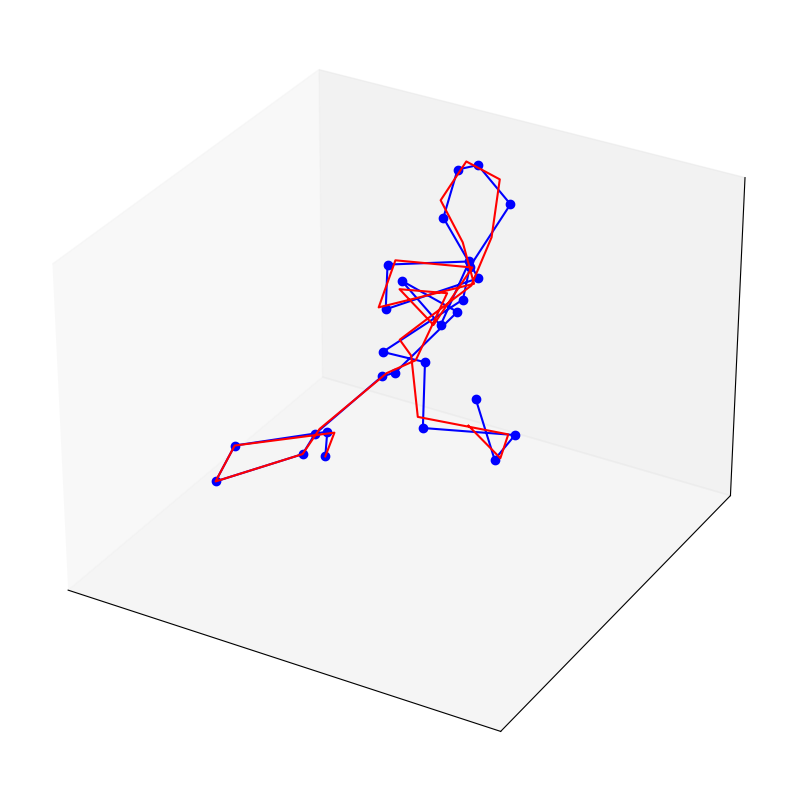

In [ ]:

xyz = md.load("Results/activation_segments/CA_segments/mustang_endsAlignment_cleaned/2JFL_A.pdb")

DFG = xyz.top.to_fasta()[0].find("DFG")
APE = xyz.top.to_fasta()[0].find("APE")+2
atoms = sum([[atom.index for atom in res.atoms if atom.name == "CA"] for res in xyz.top._residues[:]],[])

coords = xyz.xyz[0,atoms].T
x = coords[0]
y = coords[1]
z = coords[2]
new_coords = md.load("Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/2JFL_A.pdb")

atoms = sum([[atom.index for atom in res.atoms if atom.name == "CA"] for res in new_coords.top._residues[:]],[])
new_coords = new_coords.xyz[0,atoms].T
xp = new_coords[0]
yp = new_coords[1]
zp = new_coords[2]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z, 'blue',marker="o")
ax.plot3D(xp, yp, zp, 'red')
plt.tick_params(bottom=False, top=False, labelbottom=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

pdb_name = os.path.splitext(os.path.basename("Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/2JFL_A.pdb"))[0]
output_path = f"Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/{pdb_name}_CA_alignment.png"

plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to {output_path}")

Getting rid of outlier loops based on DFG and APE alignment.

In [ ]:

from pymol import cmd
from glob import glob
import os

# Print the atoms (resi, resn, name) and total count of a given selection
def print_selection_details(selection_name):
    print(f"Details for selection: {selection_name}")
    cmd.iterate(selection_name, "print(resi, resn, name)")
    count = cmd.count_atoms(selection_name)
    print(f"Number of atoms in {selection_name}: {count}")

# Main function to assess alignment of structure ends using RMSD and Euclidean distance
def process_ends_alignment(input_dir, output_dir):

    cmd.reinitialize()

    reference_pdb = "6UAN_chainD.pdb"
    cmd.load(reference_pdb, "6UAN_chainD")

    # Define selections for reference CA atoms
    cmd.select("6UAN_chainD_first_atom", "6UAN_chainD and resi 594 and name CA")
    cmd.select("6UAN_chainD_last_atom",  "6UAN_chainD and resi 623 and name CA")
    print_selection_details("6UAN_chainD_first_atom")
    print_selection_details("6UAN_chainD_last_atom")

    # Define selections for reference CA triplets (for RMSD calculation)
    cmd.select("6UAN_chainD_first3", "6UAN_chainD and resi 594-596 and name CA")
    cmd.select("6UAN_chainD_last3",  "6UAN_chainD and resi 621-623 and name CA")
    print_selection_details("6UAN_chainD_first3")
    print_selection_details("6UAN_chainD_last3")

    euclid_first_atom = []   
    euclid_last_atom  = []   
    rmsd_first3_atoms = []  
    rmsd_last3_atoms  = []  

    # Load all fitted PDB files
    fitted_pdb_files = glob(os.path.join(input_dir, "*.pdb"))
    total_structures = len(fitted_pdb_files)
    print(f"\nProcessing Ends Alignment directory: {input_dir}")
    print(f"Found {total_structures} PDB files.\n")

    structures_with_large_euclid_first = []
    structures_with_large_euclid_last  = []

    for fitted_pdb_file in fitted_pdb_files:
        print(f"Processing file: {fitted_pdb_file}")
        pdb_code = os.path.basename(fitted_pdb_file).split('.')[0]

        cmd.load(fitted_pdb_file, pdb_code)

        # Select corresponding atoms for comparison
        cmd.select(f"{pdb_code}_first_atom", f"{pdb_code} and resi 593 and name CA")
        cmd.select(f"{pdb_code}_last_atom",  f"{pdb_code} and resi 619 and name CA")

        cmd.select(f"{pdb_code}_first3_atoms", f"{pdb_code} and resi 593-595 and name CA")
        cmd.select(f"{pdb_code}_last3_atoms",  f"{pdb_code} and resi 617-619 and name CA")

        print_selection_details(f"{pdb_code}_first_atom")
        print_selection_details(f"{pdb_code}_last_atom")
        print_selection_details(f"{pdb_code}_first3_atoms")
        print_selection_details(f"{pdb_code}_last3_atoms")

        # Calculate Euclidean distance for single atoms
        try:
            d_first = cmd.rms_cur(f"{pdb_code}_first_atom", "6UAN_chainD_first_atom", matchmaker=-1)
            print(f"Euclidean distance (first atom) for {pdb_code} vs. reference: {d_first:.2f} Å")
            euclid_first_atom.append(d_first)
            if d_first > 3:
                structures_with_large_euclid_first.append(pdb_code)
        except:
            print(f"Error calculating distance for {pdb_code}_first_atom")
            euclid_first_atom.append(np.nan)

        try:
            d_last = cmd.rms_cur(f"{pdb_code}_last_atom", "6UAN_chainD_last_atom", matchmaker=-1)
            print(f"Euclidean distance (last atom)  for {pdb_code} vs. reference: {d_last:.2f} Å")
            euclid_last_atom.append(d_last)
            if d_last > 3:
                structures_with_large_euclid_last.append(pdb_code)
        except:
            print(f"Error calculating distance for {pdb_code}_last_atom")
            euclid_last_atom.append(np.nan)

         # Calculate RMSD for first and last 3-atom segments
        try:
            rms_first3 = cmd.rms_cur(f"{pdb_code}_first3_atoms", "6UAN_chainD_first3", matchmaker=-1)
            print(f"RMSD (first 3 atoms) for {pdb_code} vs. reference: {rms_first3:.2f} Å")
            rmsd_first3_atoms.append(rms_first3)
        except:
            print(f"Error calculating RMSD for {pdb_code}_first3_atoms")
            rmsd_first3_atoms.append(np.nan)

        try:
            rms_last3 = cmd.rms_cur(f"{pdb_code}_last3_atoms", "6UAN_chainD_last3", matchmaker=-1)
            print(f"RMSD (last 3 atoms)  for {pdb_code} vs. reference: {rms_last3:.2f} Å")
            rmsd_last3_atoms.append(rms_last3)
        except:
            print(f"Error calculating RMSD for {pdb_code}_last3_atoms")
            rmsd_last3_atoms.append(np.nan)

        
    print("\nStructures with Euclidean distance > 3 Å (first atom):")
    print(structures_with_large_euclid_first)
    print("Structures with Euclidean distance > 3 Å (last atom):")
    print(structures_with_large_euclid_last)

    num_large_first = len(structures_with_large_euclid_first)
    num_large_last  = len(structures_with_large_euclid_last)
    pct_large_first = (num_large_first / total_structures) * 100 if total_structures > 0 else 0.0
    pct_large_last  = (num_large_last / total_structures) * 100 if total_structures > 0 else 0.0
    print(f"\nNumber of structures > 3 Å (first atom): {num_large_first}")
    print(f"Percentage: {pct_large_first:.2f}%")
    print(f"Number of structures > 3 Å (last atom): {num_large_last}")
    print(f"Percentage: {pct_large_last:.2f}%")

    # Identify outlier structures
    outliers_3A = []
    for i, pdb_file in enumerate(fitted_pdb_files):
        if euclid_first_atom[i] > 3.0 or euclid_last_atom[i] > 3.0:
            outliers_3A.append(pdb_file)
    
    # Copy non-outlier structures to new output directory
    os.makedirs(output_dir, exist_ok=True)
    
    copied_files = 0
    for i, pdb_file in enumerate(fitted_pdb_files):
        if pdb_file not in outliers_3A:
            shutil.copy2(pdb_file, output_dir)
            copied_files += 1
    
    print(f"\nCopied {copied_files} non-outlier structures to: {output_dir}")
    print(f"Excluded {len(outliers_3A)} outlier structures")

    # Violin plot for Euclidean distances (single atoms)
    single_atom_data = [euclid_first_atom, euclid_last_atom]
    single_atom_labels = ["First Atom", "Last Atom"]

    fig_euclid, ax_euclid = plt.subplots()
    ax_euclid.violinplot(single_atom_data)
    ax_euclid.set_xticks(np.arange(1, len(single_atom_labels) + 1))
    ax_euclid.set_xticklabels(single_atom_labels)
    ax_euclid.set_ylabel("Euclidean Distance (Å)")
    ax_euclid.set_title("Single-Atom Comparison\nEnds Alignment")
    ax_euclid.set_ylim(0, 5) 


    ax_euclid.axhline(y=3.0, color='red', linestyle=':', label='Outlier cutoff')
    ax_euclid.legend()

    euclid_plot_path = os.path.join(input_dir, "single_atom_violin.png")
    fig_euclid.savefig(euclid_plot_path, dpi=300, bbox_inches="tight")
    plt.close(fig_euclid)

    # Violin plot for RMSD (three-atom segments)
    triple_atom_data = [rmsd_first3_atoms, rmsd_last3_atoms]
    triple_atom_labels = ["First Three Atoms", "Last Three Atoms"]

    fig_rmsd, ax_rmsd = plt.subplots()
    ax_rmsd.violinplot(triple_atom_data)
    ax_rmsd.set_xticks(np.arange(1, len(triple_atom_labels) + 1))
    ax_rmsd.set_xticklabels(triple_atom_labels)
    ax_rmsd.set_ylabel("RMSD (Å)")
    ax_rmsd.set_title("Three-Atom Comparison\nEnds Alignment")
    ax_rmsd.set_ylim(0, 5)

    rmsd_plot_path = os.path.join(input_dir, "three_atom_violin.png")
    fig_rmsd.savefig(rmsd_plot_path, dpi=300, bbox_inches="tight")
    plt.close(fig_rmsd)

    # Save metrics to CSV for further analysis
    results_df = pd.DataFrame({
        "pdb_id": [os.path.basename(f).split('.')[0] for f in fitted_pdb_files],
        "euclid_first_atom": euclid_first_atom,
        "euclid_last_atom": euclid_last_atom,
        "rmsd_first3_atoms": rmsd_first3_atoms,
        "rmsd_last3_atoms": rmsd_last3_atoms
    })

    csv_path = os.path.join(input_dir, "ends_alignment_metrics.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"\nRMSD and distance save: {csv_path}")


if __name__ == "__main__":

    input_directory = "Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/"
    output_directory = "Results/fitted_matlab_segments/mustang_endsAlignment_cleaned_noOutliers/"
    
    process_ends_alignment(input_directory, output_directory)

Details for selection: 6UAN_chainD_first_atom
594 ASP CA
Number of atoms in 6UAN_chainD_first_atom: 1
Details for selection: 6UAN_chainD_last_atom
623 GLU CA
Number of atoms in 6UAN_chainD_last_atom: 1
Details for selection: 6UAN_chainD_first3
594 ASP CA
595 PHE CA
596 GLY CA
Number of atoms in 6UAN_chainD_first3: 3
Details for selection: 6UAN_chainD_last3
621 ALA CA
622 PRO CA
623 GLU CA
Number of atoms in 6UAN_chainD_last3: 3

Processing Ends Alignment directory: Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/
Found 2868 PDB files.

Processing file: Results/fitted_matlab_segments/mustang_endsAlignment_cleaned/1APM_E.pdb
Details for selection: 1APM_E_first_atom
593 ASP CA
Number of atoms in 1APM_E_first_atom: 1
Details for selection: 1APM_E_last_atom
619 MET CA
Number of atoms in 1APM_E_last_atom: 1
Details for selection: 1APM_E_first3_atoms
593 ASP CA
594 PHE CA
595 GLY CA
Number of atoms in 1APM_E_first3_atoms: 3
Details for selection: 1APM_E_last3_atoms
617 LEU CA
618